In [1]:
import gc
import os
import sys
import time
import math
import torch.nn as nn

import pandas as pd
import torch
from PIL import Image
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from torchvision import transforms
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from collections import defaultdict
from itertools import product


warnings.filterwarnings("ignore", category=UserWarning)  # Disable UserWarnings
tqdm.pandas()

In [2]:
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")
val_df = pd.read_csv("./dataset/val.csv")

In [3]:
import text_preprocessing
train_df['preprocessed_text'] = train_df['caption'].progress_apply(text_preprocessing.text_preparation_with_spell_correction)
val_df['preprocessed_text'] = val_df['caption'].progress_apply(text_preprocessing.text_preparation_with_spell_correction)
test_df['preprocessed_text'] = test_df['caption'].progress_apply(text_preprocessing.text_preparation_with_spell_correction)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\allex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\allex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\allex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


a world war iiera bomber flying out of formation
a domesticated carnivorous mammal that typically haas a long snout an acute sense off smell <unk> claws and barking y howling or whining voice


100%|██████████| 2000/2000 [16:05<00:00,  2.07it/s]


In [4]:
train_df

,id,caption,image_id,label,preprocessed_text
0,417812c5-0ce4-499d-b97d-4d28827239bc,Wet elephants shake water onto people bathing ...,394330,0,wet elephants shake water onto people bathing ...
1,5ac91fa3-55f2-4cb3-8c8f-ad84f78e6b36,Two men holding tennis racquets on the court,130849,0,two men holding tennis racquets on the court
2,d2705b90-8347-4cab-a7a6-654540d9a489,A bird on a tree limb with mountains in the ba...,514790,0,a bird on a tree limb with mountains in the ba...
3,a3b33fe7-3085-4433-9c18-8814803891b4,A kitchen and dining room are featured along w...,182096,0,a kitchen and dining room are featured along w...
4,1514b0e4-0665-45bc-ab32-52fce326cc29,A fruit stand has various fruits on the table.,68788,1,a fruit stand has various fruits on the table
...,...,...,...,...,...
9995,1d1df243-485d-4b29-82c8-7e34c0de1f5c,Several people stand in a field flying a kite.,522702,0,several people stand in a field flying a kite
9996,f7dfa883-e524-4974-b5ba-6b3c3db49087,A batter hitting a pitch at a baseball game.,441874,1,a batter hitting a pitch at a baseball game
9997,602e83dc-6539-4c1a-8d19-c1481b5c24bf,A person on white surfboard next to group in a...,166716,0,a person on white surfboard next to group in a...
9998,d9ce2e8c-0831-466a-8756-4c40d772b1ce,A baseball player getting ready to swing at th...,517601,0,a baseball player getting ready to swing at th...


In [5]:
from collections import Counter


def build_simple_vocab(sentences, special_tokens=None, min_freq=5, max_freq=2000):
    """
    Create a vocabulary from a list of tokenized sentences with frequency filtering.
    
    Args:
        sentences (list of str): List of sentences to build vocabulary from.
        special_tokens (list of str): Special tokens like <pad>, <unk>.
        min_freq (int): Minimum frequency for a token to be included in the vocabulary.
        max_freq (int or None): Maximum frequency for a token to be included (None for no limit).
        
    Returns:
        dict: A vocabulary mapping tokens to indices.
        dict: An inverse vocabulary mapping indices to tokens.
    """
    special_tokens = special_tokens or ['<pad>', '<unk>', '<|startoftext|>', '<|endoftext|>']
    
    # Count token frequencies
    token_counter = Counter()
    for sentence in sentences:
        for token in sentence.split():
            if token.strip():  # Exclude empty tokens
                token_counter[token] += 1
    
    # Filter tokens based on frequency
    filtered_tokens = {token for token, freq in token_counter.items() 
                       if freq >= min_freq and (max_freq is None or freq <= max_freq)}
    
    # Build vocabulary
    vocab = defaultdict(lambda: len(vocab))  # Default index is the current vocab size
    for token in special_tokens:
        vocab[token]  # Add special tokens first
    
    # Add filtered tokens
    for token in filtered_tokens:
        vocab[token]
    
    # Convert to a normal dict (no longer dynamic)
    vocab = dict(vocab)
    inverse_vocab = {index: token for token, index in vocab.items()}
    return vocab, inverse_vocab


# Custom Dataset Class
class PreprocessingDataset(Dataset):
    def __init__(self, dataframe, vocab, images_path, image_transform, train=True, max_len=None):
        """
        Dataset for preprocessing image-text pairs.

        Args:
            dataframe (pd.DataFrame): DataFrame containing 'image_id', 'sentence', and optionally 'label'.
            vocab (Vocab): Vocabulary for text vectorization.
            train (bool): Whether this is a training dataset.
            max_len (int): Maximum length for sentences. If None, no truncation.
        """
        super().__init__()
        self.dataframe = dataframe
        self.vocab = vocab
        self.train = train
        self.max_len = max_len
        self.images_path = images_path

        # Define image transformations
        self.image_transform = image_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Process image
        image_path = f"{self.images_path}{row['image_id']}.jpg"
        image = self.get_image(image_path)
        
        # Process sentence
        sentence = row['caption']
        vectorized_sentence = self.vectorize(sentence, self.vocab)
        
        if self.train:
            label = row['label']
            label = torch.tensor(label, dtype=torch.long)
            return {
                'images': image,
                'captions': vectorized_sentence,
                'labels': label
            }
        else:
            return {
                'images': image,
                'captions': vectorized_sentence,
                'id': row['id']
            }
        
        
    def vectorize(self, sentence, vocab):
        unk_idx = vocab.get('<unk>', -1)
        if unk_idx == -1:
            raise ValueError("The vocabulary must include '<unk>' for unknown tokens.")
    
        # Split sentence into tokens and map them to indices
        tokens = ['<|startoftext|>'] + [token for token in sentence.split() if token.strip()] + ['<|endoftext|>']
        vectorized_sentence = torch.tensor([vocab.get(token, unk_idx) for token in tokens], dtype=torch.long)
        
        # Pad or truncate the sentence
        if len(vectorized_sentence) < self.max_len:
            padding_length = self.max_len - len(vectorized_sentence)
            pad_tensor = torch.full((padding_length,), self.vocab['<pad>'], dtype=torch.long)
            padded_sentence = torch.cat((vectorized_sentence, pad_tensor), dim=0)
        else:
            padded_sentence = vectorized_sentence[:self.max_len]
        
        return padded_sentence
    
    def get_image(self, image_path):
        pil_image = Image.open(image_path).convert("RGB")
        transformed_image = self.image_transform(pil_image)
        return transformed_image

In [6]:
tokenized_sentence = [sentence.split(" ") for sentence in train_df['preprocessed_text']]
max_len = max(len([token for token in sentence.split(" ")]) for sentence in train_df['preprocessed_text'])
print(max_len)
vocab, inverse_vocab = build_simple_vocab(train_df['preprocessed_text'])

45


In [7]:
transform_config = {
    'train': transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    # transforms.RandomPerspective(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                             std=[0.26862954, 0.26130258, 0.27577711])
    ])
}

In [8]:
train_dataset = PreprocessingDataset(train_df, vocab, train=True, max_len=max_len, images_path = "./dataset/train_images/", image_transform=transform_config['train'])
val_dataset = PreprocessingDataset(val_df, vocab, train=True, max_len=max_len, images_path ="./dataset/val_images/", image_transform=transform_config['test'])
test_dataset = PreprocessingDataset(test_df, vocab, train=False, max_len=max_len, images_path = "./dataset/test_images/", image_transform=transform_config['test'])

In [9]:
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [237]:
class VisionModule(nn.Module):
    def __init__(self, in_channels=3, num_filters=[4, 8, 16], kernel_sizes=[3, 3, 3], pool_kernel_size=2):
        super(VisionModule, self).__init__()
        
        layers = []
        input_channels = in_channels
        
        # Create a sequence of Conv2D -> ReLU -> MaxPool layers
        for i in range(len(num_filters)):
            layers.append(nn.Conv2d(input_channels, num_filters[i], kernel_size=kernel_sizes[i], padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm2d(num_filters[i]))
            layers.append(nn.Dropout(0.25))
            layers.append(nn.MaxPool2d(kernel_size=pool_kernel_size))
            input_channels = num_filters[i]
        
        self.feature_extractor = nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten the features
        return x

In [238]:
model = VisionModule()
input_tensor = torch.randn(32, 3, 100, 100)
features = model(input_tensor)
print(features.shape)

torch.Size([32, 2304])


In [235]:
class TextModule(nn.Module):
    def __init__(self, vocab_size=len(vocab), embedding_dim=16, kernel_sizes=[3, 4, 5], num_filters=16, dropout=0.25):
        super(TextModule, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv1d(embedding_dim, num_filters, kernel_size) for kernel_size in kernel_sizes])
        self.norms = nn.ModuleList([nn.BatchNorm1d(num_filters) for _ in kernel_sizes])  # Batch normalization for each conv layer
        self.dropout = nn.Dropout(dropout)  # Dropout for regularization

    def forward(self, x):
        x = self.embedding(x)  # Convert token indices to embeddings
        x = x.permute(0, 2, 1)  # Rearrange for Conv1d [batch_size, embedding_dim, seq_len]
        
        # Apply convolution, normalization, activation, and dropout
        feature_maps = []
        for conv, norm in zip(self.convs, self.norms):
            conv_out = torch.relu(conv(x))  # Convolution + ReLU
            conv_out = norm(conv_out)  # Apply normalization
            conv_out = self.dropout(conv_out)  # Apply dropout
            pooled_out = torch.max_pool1d(conv_out, conv_out.shape[2]).squeeze(2)  # Max pooling
            feature_maps.append(pooled_out)
        
        x = torch.cat(feature_maps, dim=1)  # Concatenate all feature maps
        return x  # Return the extracted features


In [236]:
vocab_size = len(vocab)  # Example vocabulary size
model = TextModule(vocab_size)
input_tensor = torch.randint(0, vocab_size, (batch_size, max_len))  # Example input
features = model(input_tensor)  # Extracted features
print(features.shape)

torch.Size([32, 48])


In [239]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.vision_model = VisionModule()
        self.vision_features = nn.Linear(in_features=2304, out_features=128)
        
        self.text_model = TextModule()
        # self.LSTM = nn.LSTM(input_size=64, hidden_size=32, batch_first=True, bidirectional=False)
        self.text_features = nn.Linear(in_features=48, out_features=128)
        
        self.concatenated_features = nn.Linear(in_features=256, out_features=128)
        
        self.clasification_head = nn.Linear(in_features=128, out_features=1)
        
        self.activation = nn.ReLU()
        self.text_dropout = nn.Dropout(.2)
        self.vision_dropout = nn.Dropout(.2)
        
    def forward(self, images, captions):
        im_features = self.vision_model(images)
        im_features = self.vision_features(im_features)
        im_features = self.vision_dropout(self.activation(im_features))
        
        # txt_features = self.text_model(captions)
        # txt_features = txt_features.unsqueeze(1)  # (batch_size, seq_len=1, feature_dim)
        # _, (txt_features, _) = self.LSTM(txt_features)
        # txt_features = txt_features.squeeze(0)  # (batch_size, feature_dim)
        # txt_features = self.text_dropout(self.activation(txt_features))
        
        txt_features = self.text_model(captions)
        txt_features = self.text_features(txt_features)
        txt_features = self.text_dropout(self.activation(txt_features))
        
        concatenated_features = torch.cat((im_features, txt_features), dim=1)
        concatenated_features = self.concatenated_features(concatenated_features)
        
        logits = self.clasification_head(concatenated_features)
        predictions = torch.sigmoid(logits).squeeze(1)
        return predictions # probability

In [240]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm1d) or isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)  # Initialize BatchNorm weight to 1
        nn.init.zeros_(m.bias)  # Initialize BatchNorm bias to 0

In [241]:
# Test model code
#  , num_heads, transformer_hidden_dim, num_transformer_layers
model = Model()

# Apply weight initialization recursively
model.apply(initialize_weights)

# Dummy input data
images = torch.randn(16, 3, 100, 100)  # Batch of 16 RGB images of size 224x224
captions = torch.randint(0, len(vocab), (16, max_len))  # Batch of 16 captions with max_len tokens each

output = model(images, captions)
print(output)  # Should be (16) 

tensor([0.0145, 0.0012, 0.0785, 0.0253, 0.0060, 0.0018, 0.0138, 0.0343, 0.1588,
        0.0007, 0.0197, 0.0123, 0.0330, 0.0083, 0.0860, 0.0081],
       grad_fn=<SqueezeBackward1>)


In [242]:
# Initialize the model
model_config = {
    
}
model = Model()
model.to(device)
model.apply(initialize_weights)

Model(
  (vision_model): VisionModule(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.25, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Dropout(p=0.25, inplace=False)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): Dropout(p=0.25, inplace=False)
      (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

In [243]:
import transformers

criterion = nn.BCELoss()  # Use logits directly
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-5)
 # T_0 -> Number of iterations until the first restart
 # T_mult -> Double the cycle length after every restart
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [10, 30, 45], gamma=0.2)
epochs = 70
# num_train_steps = int(len(train_dataloader) / batch_size) * epochs
# num_warmup_steps = int(0.1 * num_train_steps)
# scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=5,  # Number of epochs before the first restart
    T_mult=1,  # Multiplicative factor for increasing restart period
    eta_min=5e-6  # Minimum learning rate
)

In [244]:
import copy

def plot_gradients(model, layer_name):
    # Find the layer with the specified name
    for name, param in model.named_parameters():
        if name == layer_name and param.grad is not None:
            gradients = param.grad.cpu().detach().numpy()  # Convert gradients to a NumPy array

            # Flatten the gradients for visualization
            flattened_gradients = gradients.flatten()

            # Plot the histogram of gradients
            plt.figure(figsize=(10, 6))
            plt.hist(flattened_gradients, bins=50, color='blue', alpha=0.7)
            plt.title(f"Gradient Distribution for Layer: {layer_name}")
            plt.xlabel("Gradient Value")
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.show()

            # Plot the gradient values as a line plot
            plt.figure(figsize=(10, 6))
            plt.plot(flattened_gradients, color='red', alpha=0.7)
            plt.title(f"Gradient Values for Layer: {layer_name}")
            plt.xlabel("Parameter Index")
            plt.ylabel("Gradient Value")
            plt.grid(True)
            plt.show()

            return  # Exit after finding and plotting the layer's gradients

    print(f"Layer {layer_name} not found or has no gradients.")


def monitor_gradients(model):
    grad_info = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            grad_info.append((name, grad_norm))
    return grad_info


def training_method(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader, patience=10, delta = 0.02, loss_procentage_improvement=10, gradient_clip=10.0):
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    val_accuracies = []  # List to store validation accuracies
    val_precisions = []  # List to store validation precisions
    val_recalls = []  # List to store validation recalls
    val_f1s = []  # List to store validation F1-scores
    learning_rates = [] # List to store learning rate progression

    best_val_loss = float('inf')  # Initialize the best validation loss
    initial_loss = float('inf')
    best_model = None  # Store the best model
    epochs_without_improvement = 0  # Track epochs without improvement

    for epoch in range(num_epochs):
        start_time = time.time()
        ### TRAINING
        model.train()
        training_loss = 0.0
        for batch_idx, batch in enumerate(train_loader):
            images = batch['images'].to(device)      # Images from batch
            captions = batch['captions'].to(device)  # Captions from batch
            labels = batch['labels'].to(device).float()  # Binary labels (0/1), converted to float
            
            optimizer.zero_grad()  # Reset gradients
            output = model(images, captions)  # Forward pass (logits)
            loss = criterion(output, labels)  # Compute loss
            loss.backward()  # Backpropagation
            
            # Monitor gradient norms
            grad_info = monitor_gradients(model)
            for layer_name, grad_norm in grad_info:
                if grad_norm > 20:
                    print(f"Warning: Exploding gradient detected in layer {layer_name} with norm {grad_norm:.2f} at batch {batch_idx}")
                    # plot_gradients(model, layer_name)

                
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=gradient_clip)
            
            optimizer.step()  # Update weights
            training_loss += loss.item()  # Accumulate loss
        
        train_loss = training_loss / len(train_loader)  # Average training loss
        train_losses.append(train_loss)

        ### VALIDATING
        model.eval()
        validation_loss = 0.0
        all_labels = []  # Ground truth labels for validation
        all_preds = []   # Predictions for validation
        
        with torch.no_grad():
            for batch in val_loader:
                images = batch['images'].to(device)
                captions = batch['captions'].to(device)
                labels = batch['labels'].to(device).float()
                output = model(images, captions)  # Forward pass (logits)
                loss = criterion(output, labels)  # Compute validation loss
                validation_loss += loss.item()
                
                # Convert logits to probabilities and apply threshold
                preds = (output > 0.5).float()
                
                # Store for statistics
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                
        val_loss = validation_loss / len(val_loader)  # Average validation loss
        val_losses.append(val_loss)
        print(f"{sum(all_preds)=}")
        
        # Compute validation statistics
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds, zero_division=0)
        val_recall = recall_score(all_labels, all_preds, zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)
        
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)
        
        if epoch == 1:
            initial_loss = val_loss

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)  # Save the best model
            epochs_without_improvement = 0  # Reset counter
            print(f"New best model with Loss: {val_loss:.4f} at epoch {epoch + 1}")
        elif val_loss < best_val_loss + delta:
            print(f"Validation loss did not improve significantly")            
        else:
            epochs_without_improvement += 1
            print(f"Validation loss did not improve for {epochs_without_improvement} epoch(s).")
            # Stop training if validation loss does not improve for 'patience' epochs
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Loss: {best_val_loss:.4f}")
                break  # Exit training loop


        # Step the learning rate scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']  # Get the current learning rate
        learning_rates.append(current_lr)
        end_time = time.time()

        print(f"\nEpoch {epoch + 1}/{num_epochs} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Loss: {val_loss:.4f} - "
              f"Accuracy: {val_accuracy:.4f} - "
              f"Precision: {val_precision:.4f} - "
              f"Recall: {val_recall:.4f} - "
              f"F1 Score: {val_f1:.4f} - "
              f"Time: {end_time - start_time:.2f} - "
              f"Lr: {current_lr:.2e}")

    print('Training finished!')
    
    # save the model only if the best loss is lower than the first initial loss ( to see that the model actually improved with 10% loss )
    if best_val_loss < (100 - loss_procentage_improvement) * initial_loss:
        # Init plot&model save path
        plt_save_path = "models/"
        model_config['eval_loss'] = best_val_loss
        for key, value in model_config.items():
            plt_save_path += key + "=" + str(value) + "+"
        plt_save_path = plt_save_path[:-1] + ".png"
        model_path = plt_save_path[:-4] + ".pt"
        torch.save(best_model.state_dict(), model_path)
        print(f"Best model with Loss: {best_val_loss:.4f} saved.")
        print(f"Model saved to {model_path}")

        # Plotting the losses and validation metrics over epochs
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        plt.subplot(3, 1, 2)
        plt.plot(val_accuracies, label='Accuracy')
        plt.plot(val_precisions, label='Precision')
        plt.plot(val_recalls, label='Recall')
        plt.plot(val_f1s, label='F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('Metric')
        plt.title('Validation Metrics')
        plt.legend()
        
        plt.subplot(3, 1, 3)
        plt.plot(learning_rates, label='Learning Rate')
        plt.xlabel("Epochs")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Progression")
        plt.legend()
    
        plt.tight_layout()
        plt.savefig(plt_save_path)
        plt.show()
    
    else:
        print(f"Model wasn't saved because it didn't improve: {loss_procentage_improvement}%")

sum(all_preds)=1498.0
New best model with Loss: 0.7119 at epoch 1

Epoch 1/70 - Training Loss: 0.9694 - Validation Loss: 0.7119 - Accuracy: 0.5280 - Precision: 0.5280 - Recall: 0.5273 - F1 Score: 0.5277 - Time: 22.27 - Lr: 4.57e-05
sum(all_preds)=1853.0
New best model with Loss: 0.7042 at epoch 2

Epoch 2/70 - Training Loss: 0.7622 - Validation Loss: 0.7042 - Accuracy: 0.5290 - Precision: 0.5235 - Recall: 0.6467 - F1 Score: 0.5786 - Time: 19.64 - Lr: 3.45e-05
sum(all_preds)=2048.0
New best model with Loss: 0.7017 at epoch 3

Epoch 3/70 - Training Loss: 0.7228 - Validation Loss: 0.7017 - Accuracy: 0.5327 - Precision: 0.5239 - Recall: 0.7153 - F1 Score: 0.6048 - Time: 19.57 - Lr: 2.05e-05
sum(all_preds)=2102.0
New best model with Loss: 0.7007 at epoch 4

Epoch 4/70 - Training Loss: 0.7046 - Validation Loss: 0.7007 - Accuracy: 0.5367 - Precision: 0.5262 - Recall: 0.7373 - F1 Score: 0.6141 - Time: 19.75 - Lr: 9.30e-06
sum(all_preds)=1799.0
New best model with Loss: 0.6960 at epoch 5

Epoch

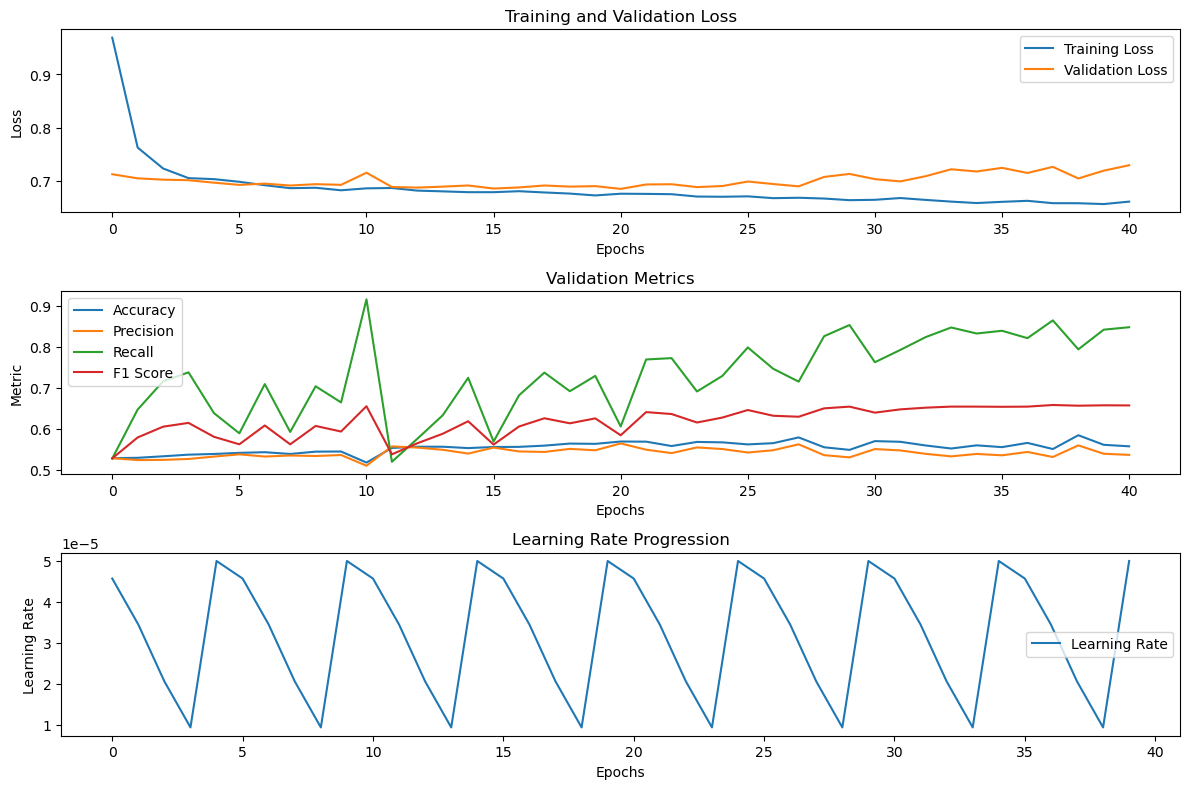

In [245]:
training_method(model, criterion, optimizer, scheduler, num_epochs=epochs, train_loader=train_dataloader, val_loader=val_dataloader)

In [ ]:
ids = []
predictions = []

def make_submission(model, test_loader):
    model.eval()

    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            id = batch['id']
            
            output = model(images, captions)
            preds = (output > 0.5).int()
            
            ids.extend(id)
            predictions.extend(preds.cpu().tolist())
    df = pd.DataFrame({'id': ids, 'label': predictions})
    df.to_csv('submission3.csv', index=False)

In [78]:
# # LOAD MODEL FROM PATH
# model_config = {
#     "vocab_size": len(vocab),
#     "embedding_dim": 128,
#     "num_filters": 128,
#     "filter_sizes": [3, 4, 5, 6, 7, 8],
#     "seq_len": max_len,
#     "cnn_text_drop_value": 0.5,
#     "cnn_dropout_value": 0.4,
#     "head_dropout_value": 0.5,
#     "num_classes": 1,
# }
# model = ImageTextClassifier(**model_config)
# model_path = "vocab_size=3733+embedding_dim=128+num_filters=128+filter_sizes=[3, 4, 5, 6, 7, 8]+seq_len=53+cnn_text_drop_value=0.5+cnn_dropout_value=0.4+head_dropout_value=0.5+num_classes=1+eval_loss=0.6202353974606128.pt"
# model.load_state_dict(torch.load(model_path, weights_only=True))
# model.to(device)

In [79]:
make_submission(model, test_dataloader)

100%|██████████| 63/63 [00:01<00:00, 35.14it/s]


In [80]:

def hyperparameter_tuning(vocab_size, max_len, train_loader, val_loader, param_grid, training_method, num_epochs=200):

    # Create all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]
    
    for params in tqdm(param_combinations):
        print(f"Testing configuration: {params}")
        
        try:
            # Update model configuration
            model_config = {
                "vocab_size": vocab_size,
                "embedding_dim": params["embedding_dim"],
                "num_filters": params["num_filters"],
                "filter_sizes": params["filter_sizes"],
                "seq_len": max_len,
                "cnn_text_drop_value": params["cnn_text_drop_value"],
                "cnn_dropout_value": params["cnn_dropout_value"],
                "head_dropout_value": params["head_dropout_value"],
            }
            
            # Initialize model
            model = ImageTextClassifier(**model_config)
            model.to(device)
            model.apply(initialize_weights)
            
            # Define criterion, optimizer, and scheduler
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.AdamW(
                model.parameters(), 
                lr=params["lr"], 
                weight_decay=params["weight_decay"]
            )
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, 
                T_0=params["T_0"],
                eta_min=params["eta_min"],
            )
            
            # Train the model
            training_method(
                model, criterion, optimizer, scheduler,
                num_epochs=num_epochs,
                train_loader=train_loader,
                val_loader=val_loader
            )
            print(f"Completed configuration: {params}")
        
        except RuntimeError as e:
            print(f"Error with configuration: {params}")
            print(f"Error message: {str(e)}")
        
        finally:
            # Reset GPU memory
            print("Resetting GPU memory...")
            torch.cuda.empty_cache()
            gc.collect()

In [81]:
param_grid = {
    "embedding_dim": [128],
    "num_filters": [16],
    "filter_sizes": [[3, 4, 5],[3, 4, 5, 6, 7, 8, 9]],
    "head_dropout_value": [0.5],
    "cnn_text_drop_value": [0.5],
    "cnn_dropout_value": [0.5],
    "lr": [1e-5, 1e-4, 5e-4, 1e-3, 5e-3],  # Learning rate candidates
    "weight_decay": [1e-6, 1e-5, 1e-4, 1e-3],  # Weight decay candidates
    "T_0": [10],  # Number of epochs for the first cycle
    "T_mult": [1],  # Cycle multiplier
    "eta_min": [1e-6, 1e-5, 1e-4],  # Minimum learning rate
}

total_combinations = math.prod(len(values) for values in param_grid.values())
print(f"Total combinations: {total_combinations}")

time_per_epoch = 23  # seconds
num_epochs = 100  # epochs per configuration
total_time_seconds = total_combinations * time_per_epoch * num_epochs

# Convert to hours
total_time_hours = total_time_seconds / 3600
print(f"Total time to hyper tune: {total_time_hours} hours")

Total combinations: 120
Total time to hyper tune: 76.66666666666667 hours


In [82]:
results = hyperparameter_tuning(
    vocab_size=len(vocab),
    max_len=max_len,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    param_grid=param_grid,
    training_method=training_method,
    num_epochs=100
)

  0%|          | 0/120 [00:00<?, ?it/s]

Testing configuration: {'embedding_dim': 128, 'num_filters': 16, 'filter_sizes': [3, 4, 5], 'head_dropout_value': 0.5, 'cnn_text_drop_value': 0.5, 'cnn_dropout_value': 0.5, 'lr': 1e-05, 'weight_decay': 1e-06, 'T_0': 10, 'T_mult': 1, 'eta_min': 1e-06}
Resetting GPU memory...


NameError: name 'ImageTextClassifier' is not defined

In [ ]:
dir_models = os.listdir("./models")

In [ ]:
best_models = [path[:-3] for path in dir_models if path.endswith(".pt")]

In [ ]:
best_val_loss = [float(str(best_model.split("+")[-1:]).split("=")[1][:8]) for best_model in best_models]

In [ ]:
best_val_loss.sort()
best_val_loss[:100]